<a href="https://colab.research.google.com/github/haizznaam/Risk-Analysis-NEU/blob/main/MarketRisk-Midterm/MBB_TCB_VaR_Estimation_and_Backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Market Risk - Risk Analysis Course - NEU
****
**Yêu cầu chi tiết:**

1. **Lựa chọn danh mục đầu tư:** Mỗi nhóm được tự do lựa chọn 1 danh mục đầu tư gồm 2 tài sản (chẳng hạn như cổ phiếu) với dữ liệu giả định.
2. **Ước lượng VaR:**
    - 1. Sử dụng phương pháp BHS để mô phỏng chuỗi lợi suất (returns) cho danh mục đầu tư. (Non-parametric)

    - 2. Sử dụng phân phối chuẩn để ước tính VaR 1 ngày với độ tin cậy 99%. (Parametric)
3. **Hậu kiểm:**
    - Thực hiện hậu kiểm cho phương pháp BHS với 250 dữ liệu.
    - Áp dụng các kiểm định không điều kiện và có điều kiện để đánh giá hiệu quả của phương pháp trong việc dự đoán VaR.

    ***

# Environmetal Settings

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import norm
from scipy.stats import kurtosis, skew
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Stock Dataset

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Risk Analysis - Spring 2024_NEU/Market Risk")
print("We are currently in ", os.getcwd())

We are currently in  /content/drive/MyDrive/Risk Analysis - Spring 2024_NEU/Market Risk


In [ ]:
mbb = pd.read_csv("stock-dataset/MBB.csv")[['Ngày', 'Lần cuối']]
mbb = mbb.rename(columns={'Ngày': 'Date', 'Lần cuối': 'Last Price'})
mbb['Last Price'] = mbb['Last Price'].apply(lambda x: float(x.replace(',', '.')))
mbb['Date'] = pd.to_datetime(mbb['Date'])
mbb.head()

  mbb['Date'] = pd.to_datetime(mbb['Date'])



,Date,Last Price
0,2023-12-29,18.65
1,2023-12-28,18.55
2,2023-12-27,18.40
3,2023-12-26,18.45
4,2023-12-25,18.40


In [ ]:
tcb = pd.read_csv("stock-dataset/TCB.csv")[['Ngày', 'Lần cuối']]
tcb = tcb.rename(columns={'Ngày': 'Date', 'Lần cuối': 'Last Price'})
tcb['Last Price'] = tcb['Last Price'].apply(lambda x: float(x.replace(',', '.')))
tcb['Date'] = pd.to_datetime(tcb['Date'])
tcb.head()

  tcb['Date'] = pd.to_datetime(tcb['Date'])



,Date,Last Price
0,2023-12-29,31.80
1,2023-12-28,31.50
2,2023-12-27,30.85
3,2023-12-26,30.80
4,2023-12-25,30.95


In [ ]:
mbb.columns = ['Date', 'MBB']
mbb.set_index('Date', inplace=True)
mbb.head()

,MBB
Date,
2023-12-29,18.65
2023-12-28,18.55
2023-12-27,18.40
2023-12-26,18.45
2023-12-25,18.40


In [ ]:
tcb.columns = ['Date', 'TCB']
tcb.set_index('Date', inplace=True)
tcb.head()

,TCB
Date,
2023-12-29,31.80
2023-12-28,31.50
2023-12-27,30.85
2023-12-26,30.80
2023-12-25,30.95


In [ ]:
stocks = pd.concat([mbb, tcb], axis=1)
stocks.head()

,MBB,TCB
Date,,
2023-12-29,18.65,31.80
2023-12-28,18.55,31.50
2023-12-27,18.40,30.85
2023-12-26,18.45,30.80
2023-12-25,18.40,30.95


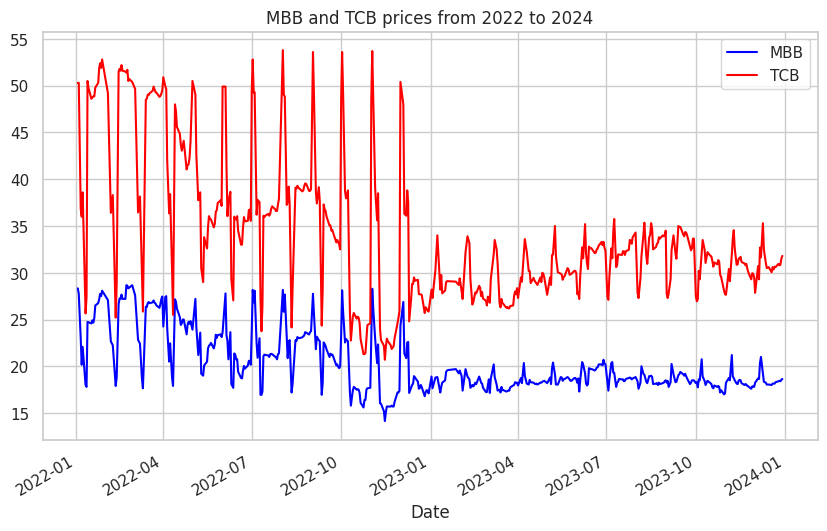

In [ ]:
stocks.plot(figsize=(10, 6), color = ['blue', 'red'])
plt.title('MBB and TCB prices from 2022 to 2024')
plt.show()

# Set an Investment Weights (Đặt trọng số tùy ý)

In [ ]:
weights = np.array([0.4, 0.6])

# Initial Investment Amount

In [ ]:
initial_investment = 100_000 # (100tr VND)
mbb_invest_amount = initial_investment * weights[0]
tcb_invest_amount = initial_investment * weights[1]

# Calculate Log of Percentage Change

In [ ]:
stocks_returns = np.log(1 + stocks.pct_change(1)).dropna()
stocks_returns

,MBB,TCB
Date,,
2023-12-28,-0.005376,-0.009479
2023-12-27,-0.008119,-0.020851
2023-12-26,0.002714,-0.001622
2023-12-25,-0.002714,0.004858
2023-12-22,-0.005450,-0.011373
...,...,...
2022-10-01,0.007157,0.004119
2022-07-01,0.017609,0.016310
2022-06-01,-0.008766,0.009059



Kết quả của `stocks_returns` sẽ là một DataFrame mới chứa tỷ lệ phần trăm thay đổi logarit của giá trị cho mỗi cặp giá trị liền kề trong các cột `mbb`,  `TCB`.

**Ý nghĩa:**

- `stocks_returns` cung cấp cho ta thông tin về mức độ biến động của cổ phiếu trong danh mục đầu tư theo thời gian.

- Giá trị dương cho thấy giá trị cổ phiếu đã tăng so với giá trị trước đó, trong khi giá trị âm cho thấy giá trị cổ phiếu đã giảm.

- Việc sử dụng logarit tự nhiên giúp ổn định dữ liệu và dễ dàng so sánh mức độ biến động giữa các cột khác nhau.

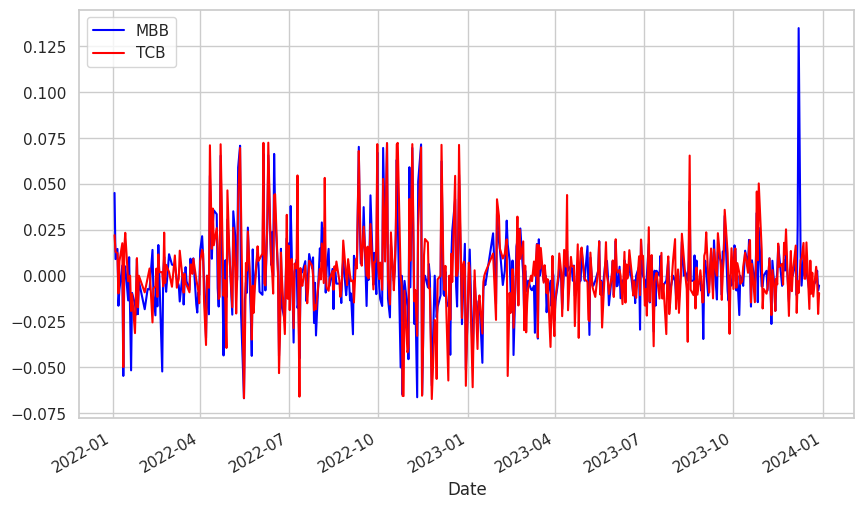

In [ ]:
stocks_returns.plot(figsize=(10, 6), color = ['blue', 'red'])
plt.show()

# **I. VaR Estimation**

## **1. Parametric Method (Normal Distribution)**

Estimating VaR with Normally Distributed Profits/Losses:

$$\text{VaR}(\alpha) = -\mu + \sigma \times z_{\alpha}$$

where $z_{\alpha}$ is the standard normal variate corresponding to $\alpha$.

### Create a Covariance Matrix Based on Returns

In [ ]:
# Generate Var-Cov Matrix
cov_matrix = stocks_returns.cov()
cov_matrix

,MBB,TCB
MBB,0.000479,0.000380
TCB,0.000380,0.000511


### Calculate the Portfolio Mean and Standard Deviation

In [ ]:
# Calculate average return
avg_returns = stocks_returns.mean()

# Calculate mean returns for portfolio overall
# using dot product to normalize individual means against investment weights
portfolio_mean = avg_returns.dot(weights)

# Calculate standard deviation of portfolio
portfolio_std = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

# Investment Mean
investment_mean = (1 + portfolio_mean) * initial_investment

# Standard Deviation of Investment
investment_std = initial_investment * portfolio_std

print('=' * 40)
print("Portfolio mean is equal to", int(investment_mean))
print("Portfolio standard deviation is equal to", round(investment_std, 2))

Portfolio mean is equal to 100077
Portfolio standard deviation is equal to 2105.28


### Inverse of the Normal Cumulative Distribution with a specifiedd Confidence Interval, Standard Devitation and Mean

In [ ]:
# Select your confidence interval
conf_level = 0.01

# Scipy ppf method is a method to generate values for the
# inverse cumulative distribution function to a normal distribution
# plugging the mean, std of our portfolio

cutoff = investment_mean + investment_std * norm.ppf(0.01)
cutoff

95180.2971307638

### **Estimating Value at Risk (VaR)**

In [ ]:
# Calculate VaR
VaR_1day = initial_investment - cutoff

print(f"Value at Risk is equal to {int(VaR_1day)}k VND, which is {round(VaR_1day/initial_investment*100,2)} percent of initial investment")

Value at Risk is equal to 4819k VND, which is 4.82 percent of initial investment


**It means with 99% of confidence a 100 million VND portfolio will not exceed losses greather than 4.82 million VND over a one day period.**

Similarly, we can estimate VaR of MBB and TCB investments.

In [ ]:
mbb_stock = stocks_returns['MBB'].values
mbb_mean = mbb_stock.mean()
mbb_std = mbb_stock.std()

# MBB Investment Mean
mbb_investment_mean = (1 + mbb_mean) * mbb_invest_amount

# MBB Standard Deviation of Investment
mbb_investment_std = mbb_invest_amount * mbb_std

print('=' * 40)
print("MBB asset mean is equal to", int(mbb_investment_mean))
print("MBB asset standard deviation is equal to", round(mbb_investment_std, 2))

print('=' * 40)
mbb_cutoff = mbb_investment_mean + mbb_investment_std * norm.ppf(0.01)
VaR_mbb_1day = mbb_invest_amount - mbb_cutoff
print(f"MBB Value at Risk is equal to {int(VaR_mbb_1day)}k VND, which is {round(VaR_mbb_1day/mbb_invest_amount*100,2)} percent of initial investment")

MBB asset mean is equal to 40021
MBB asset standard deviation is equal to 874.8
MBB Value at Risk is equal to 2013k VND, which is 5.03 percent of initial investment


In [ ]:
tcb_stock = stocks_returns['TCB'].values
tcb_mean = tcb_stock.mean()
tcb_std = tcb_stock.std()

# TCB Investment Mean
tcb_investment_mean = (1 + tcb_mean) * tcb_invest_amount

# TCB Standard Deviation of Investment
tcb_investment_std = tcb_invest_amount * tcb_std

print("=" * 40)
print("TCB asset mean is equal to", int(tcb_investment_mean))
print("TCB asset standard deviation is equal to", round(tcb_investment_std, 2))

print("=" * 40)
tcb_cutoff = tcb_investment_mean + tcb_investment_std * norm.ppf(0.01)
VaR_tcb_1day = tcb_invest_amount - tcb_cutoff
print(f"TCB Value at Risk is equal to {int(VaR_tcb_1day)}k VND, which is {round(VaR_tcb_1day/tcb_invest_amount*100,2)} percent of initial investment")

TCB asset mean is equal to 60056
TCB asset standard deviation is equal to 1355.31
TCB Value at Risk is equal to 3096k VND, which is 5.16 percent of initial investment


In [ ]:
# Create a list of assets
assets = ['MBB', 'TCB', 'Portfolio']  # Assuming 'Danh muc' refers to the total

# Create a list of exchange rates
returns = [int(mbb_invest_amount), int(tcb_invest_amount), int(initial_investment)]  # Assuming values in millions

# Create a list of VaR values
var_values = [round(VaR_mbb_1day, 1), round(VaR_tcb_1day, 1), round(VaR_1day, 1)]  # Assuming values with decimals

# Create a DataFrame
df = pd.DataFrame(list(zip(assets, returns, var_values)), columns = ['Asset', 'Amount (thoundsand VND)', 'VaR (99%, 1 day)'])

# Print the DataFrame
print("Parametric Method (Normal Distribution)")

df

Parametric Method (Normal Distribution)


,Asset,Amount (thoundsand VND),"VaR (99%, 1 day)"
0,MBB,40000,2014.0
1,TCB,60000,3096.1
2,Portfolio,100000,4819.7


### Distribution

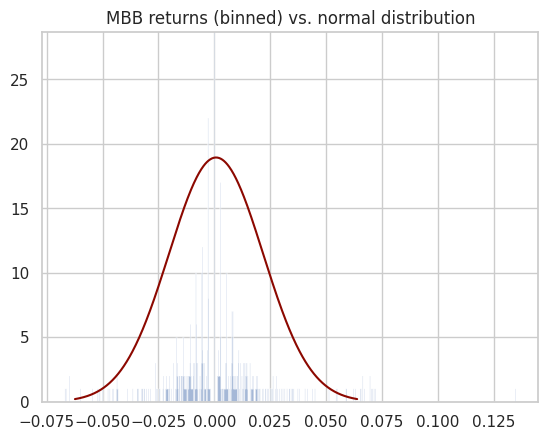

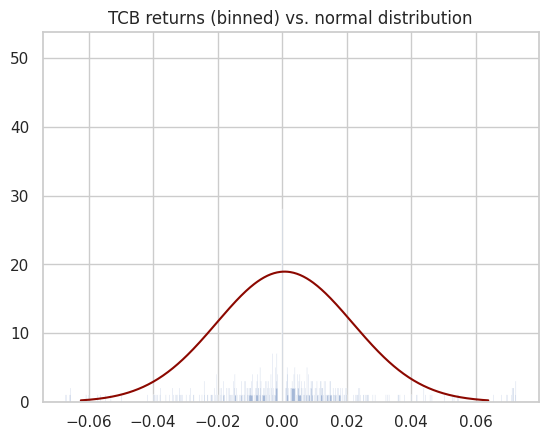

In [ ]:
stocks_names = ['MBB', 'TCB']

for name in stocks_names:
  stocks_returns[name].hist(bins = 1000, histtype = 'stepfilled', alpha = 0.5)
  x = np.linspace(portfolio_mean - 3*portfolio_std, portfolio_mean+3*portfolio_std,len(stocks_returns[name]))

  ymax = stocks[name].max()
  plt.ylim(0, ymax)
  plt.plot(x, norm.pdf(x, portfolio_mean, portfolio_std), "r")
  plt.title("{} returns (binned) vs. normal distribution".format(name))
  plt.show()

In [ ]:
stocks_returns[['MBB']]

,MBB
Date,
2023-12-28,-0.005376
2023-12-27,-0.008119
2023-12-26,0.002714
2023-12-25,-0.002714
2023-12-22,-0.005450
...,...
2022-10-01,0.007157
2022-07-01,0.017609
2022-06-01,-0.008766


## **2. Boostrap Historical Simulation Method**

In [ ]:
# Convert Returns into P&L (Profit and Loss)
PnL= (weights * stocks_returns.values).sum(axis=1)
print(PnL.shape)
PnL

(497,)


array([-7.83778919e-03, -1.57581271e-02,  1.12246126e-04,  1.82950314e-03,
       -9.00363601e-03, -2.31260760e-03, -5.90168693e-03,  4.92209487e-03,
       -1.42019299e-02,  1.19919795e-02, -9.81194004e-04, -9.82801203e-04,
        1.51310330e-02, -6.07504254e-03,  3.04216262e-03, -8.44354889e-04,
       -1.21177419e-02, -8.05446986e-03,  2.98755804e-03, -1.45865664e-02,
       -5.06332119e-03,  9.20295060e-03,  1.00250650e-03, -1.88069276e-02,
        2.08069294e-02,  8.06685031e-03,  1.40962232e-02, -1.80848409e-03,
        1.66743655e-03,  7.31615892e-03,  1.70411166e-02, -1.76623235e-03,
       -3.11379332e-03, -1.91997900e-02,  6.89502535e-04,  1.63363691e-02,
        5.68724637e-03, -3.52522154e-02,  1.11489804e-02, -1.24479635e-02,
       -2.59790216e-02, -3.54444433e-02, -1.30661070e-02,  6.25625011e-03,
        4.06390223e-02, -7.17316136e-04,  4.12614502e-02,  5.11860558e-03,
       -1.09157521e-02,  7.22764422e-03, -1.54868267e-02,  1.38919213e-02,
        1.73345784e-02,  

In [ ]:
historical_var_perc = np.percentile(PnL, 1, interpolation='lower')
historical_var_perc

-0.057656955382297155

In [ ]:
historical_var = historical_var_perc * initial_investment

print(f'The historical VaR is {round(abs(historical_var), 1)}')

The historical VaR is 5765.7


Similarly, we can estimate VaR of MBB and TCB by BHS method

In [ ]:
# HS - MBB
mbb_PnL= (weights[0] * mbb_stock)

mbb_historical_var_perc = np.percentile(mbb_PnL, 1, interpolation='lower')
mbb_historical_var = mbb_historical_var_perc * mbb_invest_amount

print(f'The MBB historical VaR is {round(abs(mbb_historical_var), 1)}')

The MBB historical VaR is 958.4


In [ ]:
# HS - TCB
tcb_PnL= (weights[1] * tcb_stock)

tcb_historical_var_perc = np.percentile(tcb_PnL, 1, interpolation='lower')
tcb_historical_var = tcb_historical_var_perc * tcb_invest_amount

print(f'The TCB historical VaR is {round(abs(tcb_historical_var), 1)}')

The TCB historical VaR is 2360.2


In [ ]:
# # Create a list of assets
# assets = ['MBB', 'TCB', 'Portfolio']  # Assuming 'Danh muc' refers to the total

# # Create a list of exchange rates
# returns = [int(mbb_invest_amount), int(tcb_invest_amount), int(initial_investment)]  # Assuming values in millions

# # Create a list of VaR values
# var_values = [round(abs(mbb_historical_var), 1), round(abs(tcb_historical_var), 1), round(abs(historical_var), 1)]  # Assuming values with decimals

# # Create a DataFrame
# df = pd.DataFrame(list(zip(assets, returns, var_values)), columns = ['Asset', 'Amount (thoundsand VND)', 'VaR (99%, 1 day)'])

# # Print the DataFrame
# print("Historical Simulation Method (BHS)")

# df

### Kurtosis and Skew

In [ ]:

# A normal distribution should have a zero skew and more importantly,
# zero kurtosis (technically 3, but SciPy subtracts 3 to normalize it)
# So the distribution of our return does have fat tails
print(f"Skew is {round(skew(PnL),2)}")
print(f"Kurtosis is {round(kurtosis(PnL),2)}")

Skew is 0.57
Kurtosis is 2.69


### **Boostrap VaR**

In [ ]:
def VaR99(data):
  return np.percentile(data, 1, interpolation='lower')

def boostrap(data, func):
  sample = np.random.choice(data, len(data))
  return func(sample)

def draw_bs_reps(data, func, size):
  """Draw bootstrap replicates."""
  bs_replicates = np.empty(size)

  for i in range(size):
    bs_replicates[i] = boostrap(data, func)
  return bs_replicates

In [ ]:
boostrap_VaR_perc = draw_bs_reps(PnL, VaR99, 1000)

bs_VaR = abs(boostrap_VaR_perc) * initial_investment

print(f'The boostrap VaR is {round(np.mean(bs_VaR), 1)}')

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return func(sample)



The boostrap VaR is 5834.4


In [ ]:
mbb_boostrap_VaR_perc = draw_bs_reps(mbb_PnL, VaR99, 1000)

mbb_bs_VaR = abs(mbb_boostrap_VaR_perc) * mbb_invest_amount
print(f'The MBB boostrap VaR is {round(np.mean(mbb_bs_VaR), 1)}')

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return func(sample)



The MBB boostrap VaR is 934.5


In [ ]:
tcb_boostrap_VaR_perc = draw_bs_reps(tcb_PnL, VaR99, 1000)

tcb_bs_VaR = abs(tcb_boostrap_VaR_perc) * tcb_invest_amount
print(f'The TCB boostrap VaR is {round(np.mean(tcb_bs_VaR), 1)}')

Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return func(sample)



The TCB boostrap VaR is 2296.7


In [ ]:
# Create a list of assets
assets = ['MBB', 'TCB', 'Portfolio']  # Assuming 'Danh muc' refers to the total

# Create a list of exchange rates
returns = [int(mbb_invest_amount), int(tcb_invest_amount), int(initial_investment)]  # Assuming values in millions

# Create a list of VaR values
var_values = [round(np.mean(mbb_bs_VaR), 1), round(np.mean(tcb_bs_VaR), 1), round(np.mean(bs_VaR), 1)]  # Assuming values with decimals

# Create a DataFrame
df = pd.DataFrame(list(zip(assets, returns, var_values)), columns = ['Asset', 'Amount (thoundsand VND)', 'VaR (99%, 1 day)'])

# Print the DataFrame
print("Boostrap Historical Simulation Method (BHS)")

df

Boostrap Historical Simulation Method (BHS)


,Asset,Amount (thoundsand VND),"VaR (99%, 1 day)"
0,MBB,40000,934.5
1,TCB,60000,2296.7
2,Portfolio,100000,5834.4


Text(0, 0.5, 'PDF')

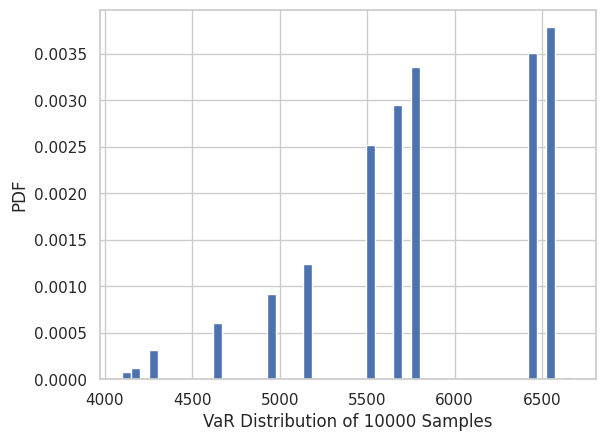

In [ ]:
plt.hist(bs_VaR, bins=50, density=True)
plt.xlabel("VaR Distribution of 10000 Samples")
plt.ylabel("PDF")

### Confidence interval

In [ ]:
conf_intervals = np.percentile(bs_VaR, [1.0, 99.0])

print(f"The 99% Boostrap VaR confidence interval is {conf_intervals}")

The 99% Boostrap VaR confidence interval is [4278.41045631 6530.39356272]


# **II. Backtesting**

**Hậu kiểm:**

- Thực hiện hậu kiểm cho phương pháp BHS với 250 dữ liệu.
- Áp dụng các kiểm định không điều kiện và có điều kiện để đánh giá hiệu quả của phương pháp trong việc dự đoán VaR.

The backtesting methods reviewed can be grouped into different categories:

- **Unconditional test methods**: Kupiec’s POF (1995) test, Kupiec’s TUFF test,
binomial distribution test, the Basel Committee’s traffic light test, the simplest backtesting method, the proportion of failures test (Haas, 2001), the scaled Crnkovic and
Drachman (1996)’s method (Haas, 2001), the risk map (Colletaz et al., 2013), the
quality control of risk measure (de la Pena et al., 2006) and the multivariate test
(Perignon and Smith, 2008).

- **Conditional test methods**: Joint test, the time between failures likelihood ratio
test (Haas, 2001), the generalized Markov tests (Pajhede, 2015), the multivariate autocorrelations test (Hurlin and Tokpavi, 2006), the dynamic binary tests (Dumitrescu
et al., 2012).

- **Independence property test methods**: the independence test (Christoffersen,
1998) and Wald statistic test (Engle and Managanelli, 2004)

## Backtesting BHS Method

## Hypothesis Testing

### Hypothesis - BHS

**Select the first 250 data points for backtesting**

In [ ]:
PnL_backtest = PnL[:250]

**Calculate VaR using BHS for the backtest data**

In [ ]:
bhs_backtest_VaR_perc = VaR99(PnL_backtest)
bhs_backtest_VaR = abs(bhs_backtest_VaR_perc) * initial_investment

print(f'The historical VaR for the backtest period is {round(abs(bhs_backtest_VaR), 1)}')


Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  bhs_backtest_VaR_perc = VaR99(PnL_backtest)



The historical VaR for the backtest period is 3791.7


In [ ]:
# Perform unconditional test
significant_level = 0.01
unconditional_test = (PnL_backtest > bhs_backtest_VaR_perc).sum() / len(PnL_backtest)
unconditional_test_pvalue = 1 - unconditional_test  # Since we want the probability of exceeding the VaR
unconditional_test_result = unconditional_test_pvalue > significant_level  # Assuming significance level of 0.01
print(f'Unconditional test p-value for BHS method: {round(unconditional_test_pvalue,3)}')
print(f'Unconditional test result for BHS method: {unconditional_test_result}')

# Perform conditional test
conditional_test_result = (PnL_backtest.mean() < bhs_backtest_VaR_perc) & (skew(PnL_backtest) > 0) & (kurtosis(PnL_backtest) > 3)
print(f'Conditional test result for BHS method: {conditional_test_result}')


Unconditional test p-value for BHS method: 0.012
Unconditional test result for BHS method: True
Conditional test result for BHS method: False


### Hypothesis Parametric Method

In [ ]:
# Calculate VaR using Parametric method
parametric_VaR_perc = norm.ppf(conf_level, portfolio_mean, portfolio_std)
parametric_VaR = abs(parametric_VaR_perc) * initial_investment

print(f'The VaR for the Parametric method is {round(abs(parametric_VaR), 1)}')

# Perform unconditional test for Parametric method
parametric_unconditional_test = (PnL_backtest > parametric_VaR_perc).sum() / len(PnL_backtest)
parametric_unconditional_test_pvalue = 1 - parametric_unconditional_test  # Since we want the probability of exceeding the VaR
parametric_unconditional_test_result = parametric_unconditional_test_pvalue > significant_level  # Assuming significance level of 0.01
print(f'Unconditional test p-value for Parametric method: {round(parametric_unconditional_test_pvalue,3)}')
print(f'Unconditional test result for Parametric method: {parametric_unconditional_test_result}')

# Perform conditional test for Parametric method
parametric_conditional_test_result = (PnL_backtest.mean() < parametric_VaR_perc) & (skew(PnL_backtest) > 0) & (kurtosis(PnL_backtest) > 3)
print(f'Conditional test result for Parametric method: {parametric_conditional_test_result}')


The VaR for the Parametric method is 4819.7
Unconditional test p-value for Parametric method: 0.008
Unconditional test result for Parametric method: False
Conditional test result for Parametric method: False


Trong đó:

- `unconditional_test`: p-value cho kiểm định không điều kiện.

- `conditional_test_BHS`: Kết quả của kiểm định có điều kiện cho phương pháp BHS.

- `parametric_unconditional_test`: p-value cho kiểm định không điều kiện cho phương pháp parametric.

- `parametric_conditional_test`: Kết quả của kiểm định có điều kiện cho phương pháp parametric.

| Method                  | VaR (thoundsand VND) | Unconditional Test p-value | Unconditional Test Result | Conditional Test Result |
|-------------------------|-----------|----------------------------|------------------|------------------|
| Bootstrap Historical    | 5765.7    | 0.012                      |  True |False           |
| Parametric             | 4819.0    | 0.008                 |  False| False            |


****